In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import matplotlib.pyplot as plt
import seaborn as sns
from TwitterDataAnalysis import processing
from nrclex import NRCLex
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import nltk
nltk.download('punkt')

%load_ext autoreload
%autoreload 2
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tabithasugumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("Data/ParisAccord_10_01.csv")

In [9]:
df.head()

,tweet_id,tweet,retweets,likes,user_id,user_name,user_followers_count,location,datetime,hashtags,urls,mentions,mentions_ids
0,1311718556283752449,The UN virtually convened on Sept 24 for its 7...,0,1,1266466029103755264,jocelyn90028,2891,"Hollywood, CA",2020-10-01 17:24:09,['ParisAccord'],['https://vimeo.com/461091177'],['realDonaldTrump'],['25073877']
1,1311690407915466753,Hey #UndecidedVoter. What's your red line to v...,0,0,744231688218238976,Mama_Liberal,7467,"Lakeland, FL",2020-10-01 15:32:17,"['UndecidedVoter', 'Divisivness', 'NATO', 'COV...",[],[],[]
2,1311637717650821120,@palkisu #carbonemissions excesses by RIC was ...,0,0,31395337,satishpanchami,15,NaN,2020-10-01 12:02:55,"['carbonemissions', 'ParisAccord']",[],['palkisu'],['49923337']
3,1311572891536896000,"EU leaders signed #ParisAccord, welcomed #EUGr...",18,25,523358647,CeliaNysss,825,Brussels,2020-10-01 07:45:19,"['ParisAccord', 'EUGreenDeal', 'PledgeForDiver...",['https://eeb.org/library/call-for-full-alignm...,"['CiolosDacian', 'Miriamdalli']","['4171877789', '55207471']"
4,1311550424319578112,#ParisAccord #ClimateCrisis #ClimateChange It ...,4,4,1220716471405420548,GovnextF,4,New Delhi,2020-10-01 06:16:03,"['ParisAccord', 'ClimateCrisis', 'ClimateChange']",[],[],[]


#### Exploratory Data Analysis

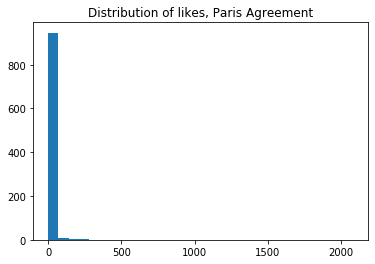

In [4]:
plt.hist(df["likes"], bins = 30)
plt.title("Distribution of likes, Paris Agreement")
plt.show()

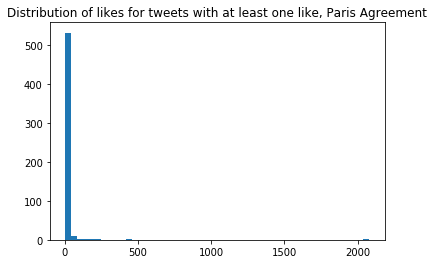

In [6]:
plt.hist(df[df["likes"] > 0]["likes"], bins = 50)
plt.title("Distribution of likes for tweets with at least one like, Paris Agreement")
plt.show()

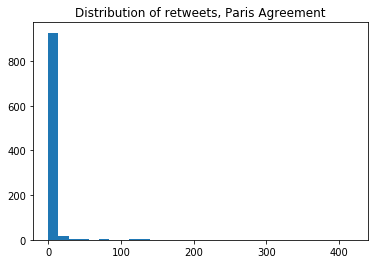

In [7]:
plt.hist(df["retweets"], bins = 30)
plt.title("Distribution of retweets, Paris Agreement")
plt.show()

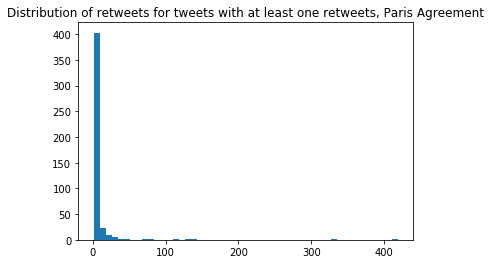

In [8]:
plt.hist(df[df["retweets"] > 0]["retweets"], bins = 50)
plt.title("Distribution of retweets for tweets with at least one retweets, Paris Agreement")
plt.show()

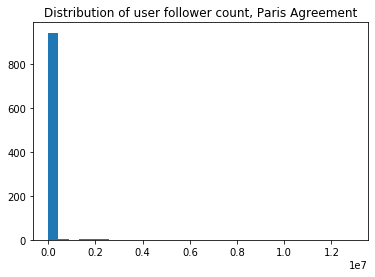

In [9]:
plt.hist(df["user_followers_count"], bins = 30)
plt.title("Distribution of user follower count, Paris Agreement")
plt.show()

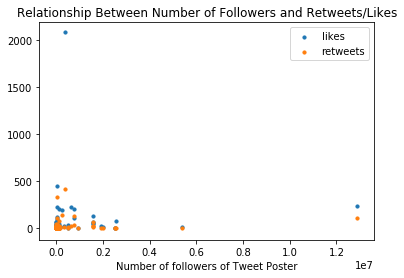

In [10]:
plt.scatter("user_followers_count", "likes", data = df, label = "likes", s = 10)
plt.scatter("user_followers_count", "retweets", data = df, label = "retweets", s = 10)
plt.xlabel("Number of followers of Tweet Poster")
plt.title("Relationship Between Number of Followers and Retweets/Likes")
plt.legend()
plt.show()

In [32]:
display(df[df["likes"] > 2000])

,tweet_id,tweet,retweets,likes,user_id,user_name,user_followers_count,location,datetime,hashtags,urls,mentions,mentions_ids
933,1308648837398102017,I welcome China’s ambition to curb emissions a...,419,2080,1146329871418843136,vonderleyen,383430,NaN,2020-09-23 06:06:11,['ParisAgreement'],[],[],[]


As expected, for both likes and retweets the vast majority of tweets are liked/favorite very few times and very very few are liked/favorite a huge number of times. It could be interesting to see who are the users that tweet the tweets with high stats. Keeping in mind that more retweets/likes generally means more people see it. However, knowing whether people feel positively or negatively toward the tweet is a very different question.

Regarding the final graph, it seems that the number of followers for this subject isn't strongly affecting the number of likes/retweets. However this may have to do with kind of engagement some users have.

#### Tweeters

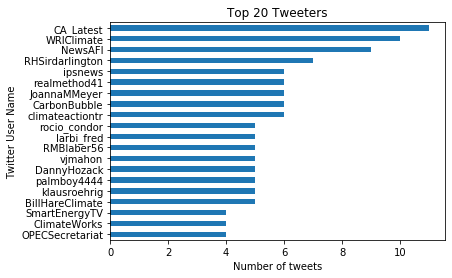

In [11]:
users = df.user_name.value_counts().sort_values()
users[-20:].plot.barh()
plt.title("Top 20 Tweeters")
plt.ylabel("Twitter User Name")
plt.xlabel("Number of tweets")
plt.show()

#### Hashtags

In [13]:
hashtags = processing.get_entities(df)

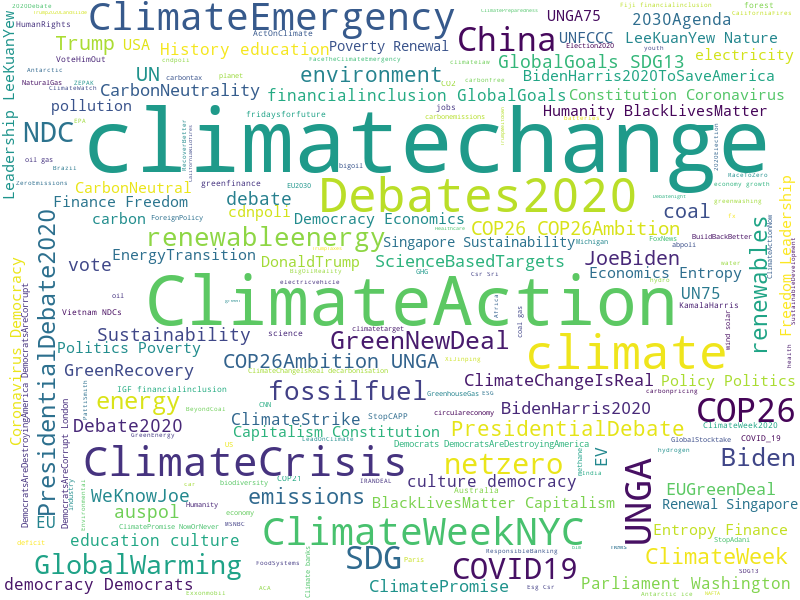

In [14]:
hashtags_cloud = WordCloud(background_color = "white", stopwords = ["ParisAgreement", "ParisAccord"], width = 800, height = 600)
hashtags_cloud.generate(" ".join(hashtags))
hashtags_cloud.to_image()

This dataset was scraped right after the debate, so it's possible that there are tweets where the sentiment has more to do with a reacion to the debate/US 2020 election, but as we continue to collect data it will likely be less of a problem.

#### Mentions

In [15]:
mentions = processing.get_entities(df, "mentions")

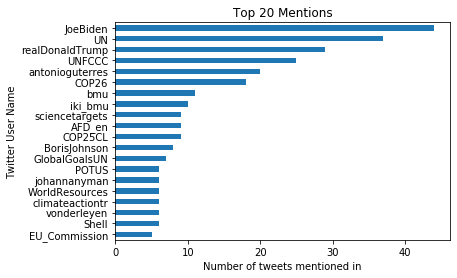

In [16]:
unique_mentions = np.unique(mentions, return_counts = True)
m = pd.Series(unique_mentions[1], index = unique_mentions[0])
m.sort_values()[-20:].plot.barh()
plt.title("Top 20 Mentions")
plt.ylabel("Twitter User Name")
plt.xlabel("Number of tweets mentioned in")
plt.show()

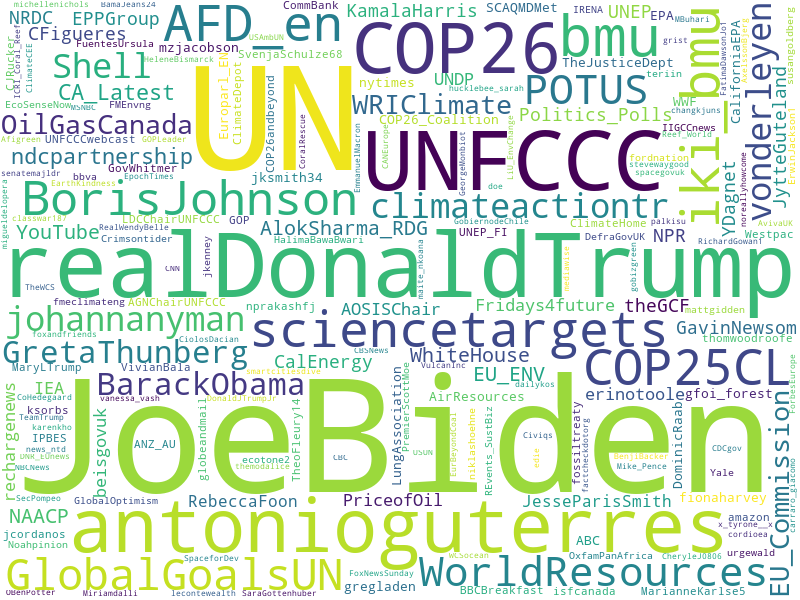

In [17]:
mentions_cloud = WordCloud(background_color = "white", width = 800, height = 600, collocations = False)
mentions_cloud.generate(" ".join(mentions))
mentions_cloud.to_image()

#### Tweets

In [3]:
tweets = df["tweet"].apply(processing.clean_text_lda)

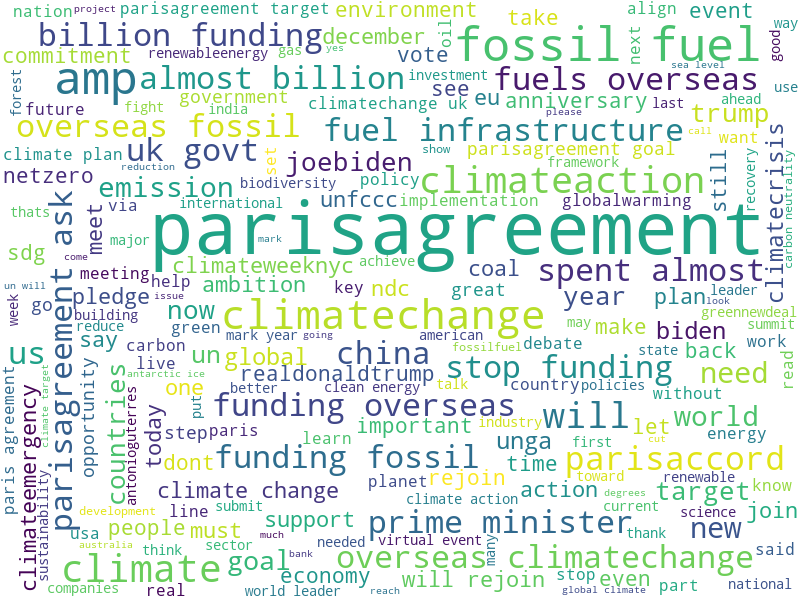

In [19]:
tweets_cloud = WordCloud(background_color = "white", stopwords = STOPWORDS, width = 800, height = 600)
tweets_cloud.generate(" ".join(list(tweets)))
tweets_cloud.to_image()

It's clear that politics is playing a part in these discussions, as well as talk about fossil fues, and funding.

#### LDA

In [20]:
count_vectorizer = CountVectorizer(stop_words = 'english')
tweet_data = count_vectorizer.fit_transform(list(tweets))

In [24]:
number_topics = 4
number_words = 10
lda = LDA(n_components = number_topics, n_jobs = -1)
lda.fit(tweet_data)

LatentDirichletAllocation(n_components=4, n_jobs=-1)

In [115]:
processing.print_top_words(lda, count_vectorizer.get_feature_names(), 20)

Topic #0: parisagreement climate climatechange amp climateaction world years event december energy unga global action anniversary parisaccord rejoin uk change coal joebiden
Topic #1: fossil funding overseas parisagreement climatechange stop fuels infrastructure uk billion govt prime fuel minister ask spent parisaccord joebiden rejoin democracy
Topic #2: parisagreement climate amp goals climatechange climateaction countries level china emissions target ndcs sea ice antarctic parisaccord sustainable met updated paris
Topic #3: parisagreement amp climate climateaction emissions carbon need new countries targets climatechange global goals china meet today plan climateweeknyc biden event


In [26]:
pyLDAvis.sklearn.prepare(lda, tweet_data, count_vectorizer)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.064008 -0.107108       1        1  31.186227
3      0.087253  0.009586       2        1  28.907018
1     -0.216618  0.001256       3        1  23.395153
2      0.065356  0.096266       4        1  16.511601, topic_info=     Category        Freq         Term       Total  loglift  logprob
1686  Default  142.000000       fossil  142.000000  30.0000  30.0000
1742  Default  140.000000      funding  140.000000  29.0000  29.0000
3084  Default  134.000000     overseas  134.000000  28.0000  28.0000
4070  Default   79.000000         stop   79.000000  27.0000  27.0000
1729  Default   74.000000        fuels   74.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
4133   Topic4    7.167888      support   26.192106   0.5053  -5.9227
3121   Topic4    9.271862  parisaccord   81.898175  -0.3774  -5.6654
2901   Topic4    7.239842         need   42.092764   0.0408  -5.9127
4705   Topic4    7.235226        world   56.439525  -0.2531  -5.9134
4190   Topic4    6.033696      targets   34.269718   0.0642  -6.0950

[273 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
17        2  0.741000  accelerate
17        3  0.211714  accelerate
42        1  0.561382      action
42        2  0.280691      action
42        4  0.153104      action
...     ...       ...         ...
4710      2  0.755192      worlds
4740      1  0.699413       years
4740      2  0.148360       years
4740      3  0.042389       years
4740      4  0.105972       years

[391 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

#### Overall Sentiment Analysis

In [4]:
nrc = NRCLex(". ".join(list(tweets)))

In [7]:
print(len(nrc.sentences))

960


In [8]:
len(df)

960

In [100]:
#Note: Unclear what these counts actually represent (more than the number of tweets (sentences))
display(pd.DataFrame(nrc.raw_emotion_scores.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency")[::-1])

,emotion,frequency
1,positive,8050
6,trust,7763
2,negative,7741
5,fear,6925
3,sadness,6808
8,anger,6807
0,anticip,6795
4,joy,6716
7,disgust,6484
9,surprise,6391


In [90]:
emotion_freq = pd.DataFrame(nrc.affect_frequencies.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency")
display(emotion_freq[::-1])

,emotion,frequency
5,positive,0.114217
3,trust,0.110145
6,negative,0.109833
0,fear,0.098255
7,sadness,0.096595
1,anger,0.096581
2,anticip,0.096410
9,joy,0.095289
8,disgust,0.091998
4,surprise,0.090678


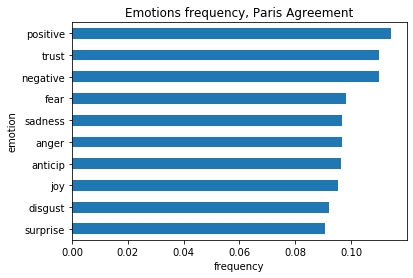

In [91]:
emotion_freq.set_index("emotion").plot.barh(legend = False)
plt.title("Emotions frequency, Paris Agreement")
plt.xlabel("frequency")
plt.ylabel("emotion")
plt.show()

In [71]:
nrc.top_emotions

[('positive', 0.11421679909194098)]

#### Sentiment Analysis with Vader

In [4]:
sa = SentimentIntensityAnalyzer()
sa_results = {tweet:sa.polarity_scores(tweet) for tweet in list(tweets)}
sa_avgs = {val:np.mean([sent[val] for sent in sa_results.values()]) for val in ["neg", "neu", "pos"]}

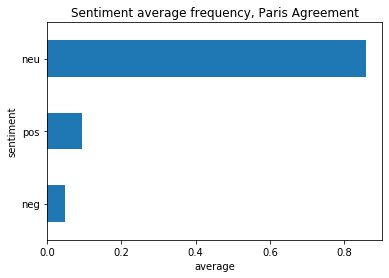

In [5]:
pos_neg_avg = pd.DataFrame(sa_avgs.items(), columns = ["sentiment", "frequency"]).sort_values(by = "frequency")
pos_neg_avg.set_index("sentiment").plot.barh(legend = False)
plt.title("Sentiment average frequency, Paris Agreement")
plt.xlabel("average")
plt.ylabel("sentiment")
plt.show()

In [6]:
display(pos_neg_avg)

,sentiment,frequency
0,neg,0.048637
2,pos,0.093460
1,neu,0.857901


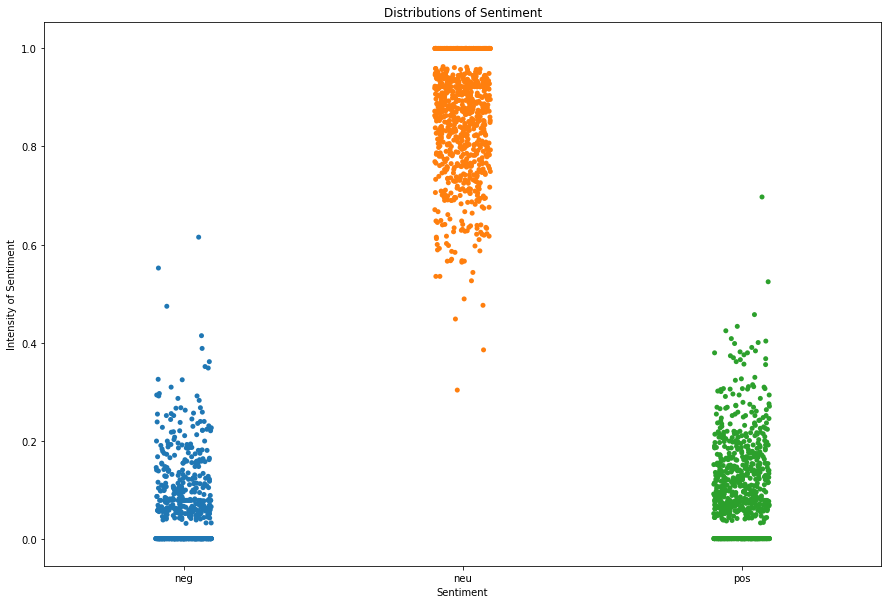

In [8]:
plt.figure(figsize=(15,10))
strp = {val:[sent[val] for sent in sa_results.values()] for val in ["neg", "neu", "pos"]}
strp = pd.DataFrame.from_dict(strp)
sns.stripplot(data = strp)
plt.title("Distributions of Sentiment")
plt.ylabel("Intensity of Sentiment")
plt.xlabel("Sentiment")
plt.show()

#### Sentiment Analysis by Topic
*I'm not very confident about the validity of this since there aren't sentences*

In [129]:
topics = []
for idx, topic in enumerate(lda.components_):
    topics.append([count_vectorizer.get_feature_names()[i] for i in topic.argsort()[:-len(topic) - 1:-1]])

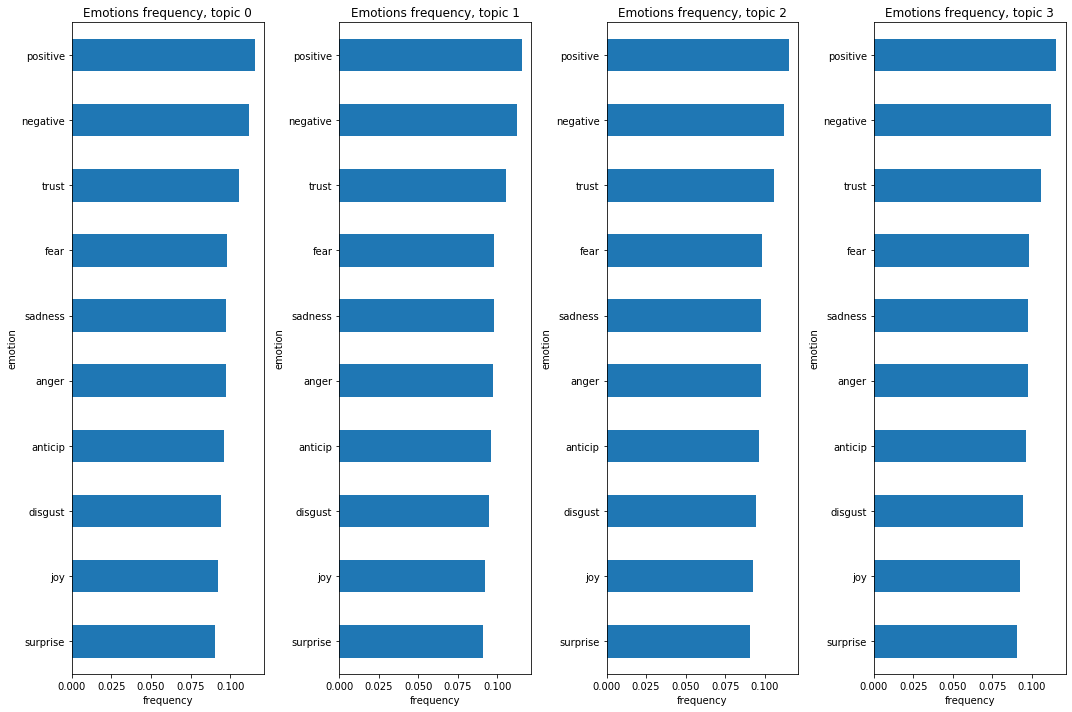

In [146]:
fig, ax = plt.subplots(1,len(topics), figsize = (15, 10))
for i in range(len(topics)):
    nrc = NRCLex(" ".join(topics[i]))
    emotion_freq = pd.DataFrame(nrc.affect_frequencies.items(), columns = ["emotion", "frequency"]).sort_values(by = "frequency").set_index("emotion")
    emotion_freq.plot.barh(ax = ax[i], legend = False)
    ax[i].set_title("Emotions frequency, topic {}".format(str(i)))
    ax[i].set_xlabel("frequency")
    ax[i].set_ylabel("emotion")
    plt.tight_layout()